## Predicting Occupancy from Sensor Data ##

We are presented with time series sensor data representing several environmental variables (CO2, light levels, temperature, humidity, etc). Each row of the data is labeled with whether or not the space was occupied (binary classification). 

We use RandomForestRegressor as an initial algorithm to explore feature importance. 

Then, we progress to a model implementation with Neural Network, fitting, then testing on previously unseen data. 

So far, the model has been able to acheive ~93% accuracy with previously unseen data. 

The data:




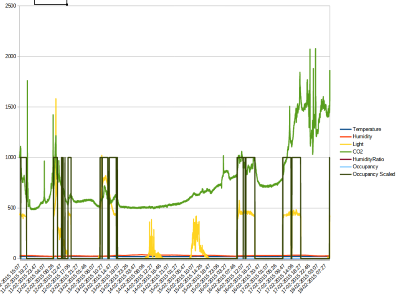

In [1]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor

from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
path = Path('Y:/ai-time-series-classification-data/OccupancyData/')
path.ls()

(#5) [Path('Y:/ai-time-series-classification-data/OccupancyData/.~lock.DataTest.csv#'),Path('Y:/ai-time-series-classification-data/OccupancyData/DataTest.csv'),Path('Y:/ai-time-series-classification-data/OccupancyData/DataTraining.csv'),Path('Y:/ai-time-series-classification-data/OccupancyData/valid_xs_imp.pkl'),Path('Y:/ai-time-series-classification-data/OccupancyData/xs_imp.pkl')]

Explore the data and examine the fields

In [3]:
df_train = pd.read_csv(path/'DataTraining.csv', low_memory=False)
df_train = df_train.iloc[:, 1:]
df_test = pd.read_csv(path/'DataTest.csv', low_memory=False)
df_test = df_test.iloc[:, 1:]

df_train[:1], df_test[:1]

(               date  Temperature  Humidity  Light     CO2  HumidityRatio  \
 0  04-02-2015 17:51        23.18    27.272  426.0  721.25       0.004793   
 
    Occupancy  
 0          1  ,
                date  Temperature   Humidity       Light          CO2  \
 0  11-02-2015 14:48        21.76  31.133333  437.333333  1029.666667   
 
    HumidityRatio  Occupancy  
 0       0.005021          1  )

In [ ]:
We must ensure that the Occupancy column is treated as a category. 

In [4]:
df_train['Occupancy'].astype('category')
df_test['Occupancy'].astype('category')
df_train[:3]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,04-02-2015 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,04-02-2015 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,04-02-2015 17:53,23.15,27.2450,426.0,713.50,0.004779,1


In [47]:
dep_var = 'Occupancy'

In [6]:
# lets try and use fastai datepart funcs to give us some ordinal date columns
df_train = add_datepart(df_train, 'date')
df_test = add_datepart(df_test, 'date')

In [7]:
df_train.columns

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy',
       'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [8]:
# we don't care about a lot of the things that add_datepart addds and we may need to drop more later
to_drop = ['Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Is_year_end',
  'Is_year_start']
df_train = df_train.drop(to_drop, axis = 1)
df_test = df_test.drop(to_drop, axis = 1)

In [9]:
cont,cat = cont_cat_split(df_train, 1, dep_var=dep_var)
cont, cat

(['Temperature',
  'Humidity',
  'Light',
  'CO2',
  'HumidityRatio',
  'Month',
  'Week',
  'Dayofweek',
  'Dayofyear',
  'Elapsed'],
 ['Year', 'Day'])

In [10]:
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))
to=TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)

In [11]:
len(to.train), len(to.valid)

(6515, 1628)

In [12]:
to.show(3)

,Year,Day,Temperature,Humidity,Light,CO2,HumidityRatio,Month,Week,Dayofweek,Dayofyear,Elapsed,Occupancy
7283,2015,2,20.889999,36.044998,0.000000,1237.000000,0.005516,9,36,2,245,1.441221e+09,0
4024,2015,2,23.100000,17.000000,288.666656,449.666656,0.002965,7,27,3,183,1.435842e+09,0
5663,2015,2,19.700001,26.700001,31.000000,427.750000,0.003785,8,31,6,214,1.438532e+09,0


In [13]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

def rf(xs, y, n_estimators=40, max_samples=4000, max_features=0.5, min_samples_leaf=5, **kwargs):
    r = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,min_samples_leaf=min_samples_leaf, oob_score=True)
    return r.fit(xs, y)

In [14]:
m = rf(xs, y)

m_rmse(m, valid_xs, valid_y)

0.076173

In [15]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.058805, 0.076173)

In [16]:
# look at the effect of n_estimators
# preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
# plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

Evaluate feature importance

In [17]:
def rf_feat_importance(m, df):
    b = {
        'cols':df.columns, 
        'imp':m.feature_importances_
    }
    b_df = pd.DataFrame(b)
    return b_df.sort_values('imp', ascending=False)

In [18]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
4,Light,0.669855
5,CO2,0.161897
2,Temperature,0.101974
11,Elapsed,0.041812
3,Humidity,0.012790
6,HumidityRatio,0.009684
8,Week,0.001371
10,Dayofyear,0.000333
9,Dayofweek,0.000158
7,Month,0.000125


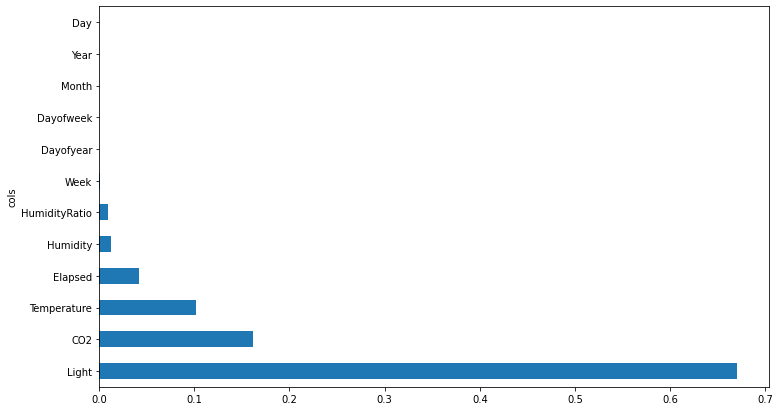

In [19]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove Low-importance variables

In [20]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

6

In [21]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [22]:
m = rf(xs_imp, y)

In [23]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.059071, 0.07657)

In [24]:
# will save here and perhaps reload later
## save em ##
save_pickle(path/'xs_imp.pkl', xs_imp)
save_pickle(path/'valid_xs_imp.pkl', valid_xs_imp)

### Prep for Neural Network ###

Here, we reload the training data and re-prepare it and get rid of columns deemed unimportant by the RandomForest model

In [25]:
df_nn = pd.read_csv(path/'DataTraining.csv', low_memory=False)
df_nn = df_nn.iloc[:, 1:]
df_nn = add_datepart(df_nn, 'date')
df_nn_final = df_nn[list(xs_imp.columns) + [dep_var]]
df_nn_final['Occupancy'].astype('category')
df_nn_final[:3], df_nn_final.columns

(   Light     CO2  Temperature       Elapsed  Humidity  HumidityRatio  \
 0  426.0  721.25        23.18  1.427997e+09   27.2720       0.004793   
 1  429.5  714.00        23.15  1.427997e+09   27.2675       0.004783   
 2  426.0  713.50        23.15  1.427997e+09   27.2450       0.004779   
 
    Occupancy  
 0          1  
 1          1  
 2          1  ,
 Index(['Light', 'CO2', 'Temperature', 'Elapsed', 'Humidity', 'HumidityRatio',
        'Occupancy'],
       dtype='object'))

In [26]:
df_nn_final = df_nn_final.astype({'Elapsed': np.float32})

In [27]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

cont_nn, cat_nn

(['Light', 'CO2', 'Temperature', 'Elapsed', 'Humidity', 'HumidityRatio'], [])

In [48]:
## it's very important for the NN to specify the y_block as a CategoryBlock or nothing works
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var,  y_block = CategoryBlock )

In [29]:
dls = to_nn.dataloaders(1024)

In [30]:
dls.show_batch()

,Light,CO2,Temperature,Elapsed,Humidity,HumidityRatio,Occupancy
0,0.00,1449.000000,21.389999,1.441219e+09,36.590000,0.005776,0
1,206.25,438.000000,23.000000,1.435844e+09,16.790001,0.002910,0
2,255.00,425.666626,19.417500,1.438518e+09,30.417500,0.004240,0
3,0.00,450.000000,21.290001,1.430526e+09,25.200001,0.003942,0
4,0.00,453.000000,20.290001,1.443773e+09,33.090000,0.004874,0
5,0.00,436.333374,19.389999,1.438490e+09,31.290001,0.004355,0
6,444.00,1722.666748,21.889999,1.441207e+09,37.060001,0.006034,1
7,0.00,445.000000,19.389999,1.438547e+09,27.500000,0.003825,0
8,0.00,443.000000,20.290001,1.433206e+09,20.790001,0.003054,0
9,539.00,802.250000,22.200001,1.433256e+09,20.650000,0.003412,1


In [31]:
y = to_nn.train.y
y.min(),y.max()

(0, 1)

In [32]:
learn = tabular_learner(dls, layers=[1000, 500], metrics=accuracy)

SuggestedLRs(valley=0.0004786300996784121)

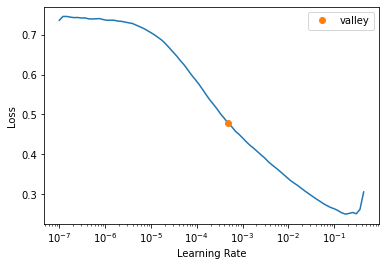

In [33]:
learn.lr_find()

In [34]:
lr=0.0003
learn.fit_one_cycle(7,lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.580572,0.572629,0.928747,00:00
1,0.393513,0.330099,0.963145,00:00
2,0.303698,0.228160,0.968673,00:00
3,0.251965,0.178079,0.972359,00:00
4,0.216790,0.140849,0.979730,00:00
5,0.191714,0.117100,0.984029,00:00
6,0.172965,0.105324,0.987715,00:00


## Test on previously unseen data ##

In [35]:
df_nn_test = pd.read_csv(path/'DataTest.csv', low_memory=False)
df_nn_test = df_nn_test.iloc[:, 1:]
df_nn_test = add_datepart(df_nn_test, 'date')
df_nn_test_final = df_nn_test[list(xs_imp.columns) + [dep_var]]
df_nn_test_final[:3]

,Light,CO2,Temperature,Elapsed,Humidity,HumidityRatio,Occupancy
0,437.333333,1029.666667,21.7600,1.446476e+09,31.133333,0.005021,1
1,437.333333,1000.000000,21.7900,1.446476e+09,31.000000,0.005009,1
2,434.000000,1003.750000,21.7675,1.446476e+09,31.122500,0.005022,1


In [36]:
df_nn_test_final['Occupancy'].astype('category')
# df_nn_test_final = df_nn_test_final.drop('Occupancy', axis=1)

0       1
1       1
2       1
3       1
4       1
       ..
9747    1
9748    1
9749    1
9750    1
9751    1
Name: Occupancy, Length: 9752, dtype: category
Categories (2, int64): [0, 1]

In [37]:
df_nn_test_final[:1]

,Light,CO2,Temperature,Elapsed,Humidity,HumidityRatio,Occupancy
0,437.333333,1029.666667,21.76,1.446476e+09,31.133333,0.005021,1


In [38]:
cont_nn,cat_nn = cont_cat_split(df_nn_test_final, max_card=9000, dep_var=dep_var)
cont_nn, cat_nn

(['Light', 'CO2', 'Temperature', 'Elapsed', 'Humidity', 'HumidityRatio'], [])

In [39]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn_test = TabularPandas(df_nn_test_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var, y_block = CategoryBlock)

test_dls = to_nn_test.dataloaders()

test_dls.show_batch()

,Light,CO2,Temperature,Elapsed,Humidity,HumidityRatio,Occupancy
0,-0.000008,678.000000,20.500000,1.424025e+09,32.790001,0.004893,0
1,-0.000008,820.500000,20.389999,1.424070e+09,24.790001,0.003667,0
2,-0.000008,533.500000,19.889999,1.423950e+09,35.290001,0.005073,0
3,-0.000008,800.000000,20.500000,1.424066e+09,25.290001,0.003767,0
4,-0.000008,522.000000,19.889999,1.423938e+09,35.500000,0.005103,0
5,-0.000008,766.000000,20.650000,1.424115e+09,30.549999,0.004599,0
6,26.000000,511.333344,20.000000,1.423925e+09,35.900002,0.005197,0
7,433.000000,973.000000,22.000000,1.424107e+09,29.889999,0.004891,1
8,429.000000,919.000000,21.790001,1.424106e+09,29.790001,0.004812,1
9,-0.000008,795.000000,20.445000,1.424066e+09,25.245001,0.003748,0


In [40]:
dl = learn.dls.test_dl(df_nn_test_final)

In [41]:
preds, actuals = learn.get_preds(dl=dl)

In [42]:
len(preds), len(actuals)

(9752, 9752)

In [43]:
preds[:10], actuals[:10]

(tensor([[4.2938e-06, 1.0000e+00],
         [7.2305e-06, 9.9999e-01],
         [6.6706e-06, 9.9999e-01],
         [5.5515e-06, 9.9999e-01],
         [6.3016e-06, 9.9999e-01],
         [5.0069e-06, 9.9999e-01],
         [5.5275e-06, 9.9999e-01],
         [4.7323e-06, 1.0000e+00],
         [5.0140e-06, 9.9999e-01],
         [4.0780e-06, 1.0000e+00]]),
 tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]], dtype=torch.int8))

In [44]:
# since this is essentially a binary classifier we can easily generate our own FP/TP/TN/FN matrix 
errors = 0.0
accuracy_ = [[0.0,0.0],[0.0,0.0]]
for i in range(len(preds)):
    
    actual = int(actuals[i])
    pred = preds[i]
    prediction = float(preds[i][1]) > float(preds[i][0])
    
    #print("Actual:" + str(int(actual[i])))
    #print(preds[i])
    
    # true positive
    if(actual == 1 and prediction == 1):
        accuracy_[0][0] = accuracy_[0][0] + 1.0
    
    # false negative
    if(actual == 1 and prediction != 1):
        accuracy_[1][0] = accuracy_[1][0] + 1.0
    
    #false positive
    if(actual != 1 and prediction == 1):
        accuracy_[0][1] = accuracy_[0][1] + 1.0
    
    #true negative
    if(actual != 1 and prediction != 1):
        accuracy_[1][1] = accuracy_[1][1] + 1.0
        
    if(actual == 1 and preds[i][1] < preds[i][0]):
        errors = errors + 1
    if(actual == 0 and preds[i][0] < preds[i][1]):
        errors = errors + 1

print(errors/len(preds))

0.07331829368334701


In [45]:
from IPython.display import display, HTML
display(HTML(pd.DataFrame(accuracy_).to_html()))

,0,1
0,2041.0,707.0
1,8.0,6996.0


In [46]:
# accuracy
accuracy_t = Tensor(accuracy_)
accuracy_val = accuracy_t.trace() / accuracy_t.sum()
print(accuracy_val)

tensor(0.9267)
